In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset

In [3]:
trainset = LibriSpeechDataset('train-clean-100',1000)

In [12]:
trainset[0]

(array([ 3.05175781e-05,  3.05175781e-05, -3.05175781e-05, -9.15527344e-05,
        -1.52587891e-04, -1.22070312e-04, -9.15527344e-05, -1.22070312e-04,
        -1.22070312e-04, -1.22070312e-04, -9.15527344e-05, -3.05175781e-05,
         0.00000000e+00,  6.10351562e-05,  9.15527344e-05,  9.15527344e-05,
         9.15527344e-05,  1.22070312e-04,  1.52587891e-04,  1.83105469e-04,
         1.22070312e-04,  1.22070312e-04,  1.52587891e-04,  1.22070312e-04,
         1.22070312e-04,  9.15527344e-05,  6.10351562e-05,  1.22070312e-04,
         9.15527344e-05,  1.83105469e-04,  2.13623047e-04,  1.83105469e-04,
         2.44140625e-04,  2.13623047e-04,  2.13623047e-04,  1.83105469e-04,
         1.22070312e-04,  9.15527344e-05,  6.10351562e-05,  6.10351562e-05,
        -3.05175781e-05, -3.05175781e-05, -6.10351562e-05, -3.05175781e-05,
         3.05175781e-05,  6.10351562e-05,  3.05175781e-05,  6.10351562e-05,
         6.10351562e-05,  6.10351562e-05,  0.00000000e+00,  3.05175781e-05,
        -3.0

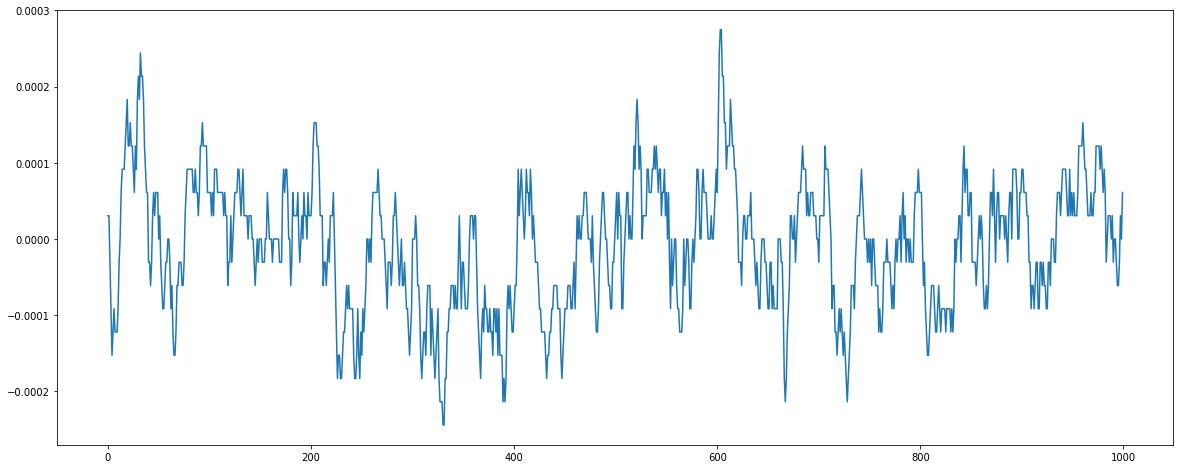

In [13]:
plt.figure(figsize=(20,8))
plt.plot(trainset[0][0])
plt.show()

In [14]:
import time

In [15]:
# t0 = time.time()
# for i, (_, _) in enumerate(trainset):
#     print i
#     if i == len(trainset)-1:
#         break
# print time.time()-t0

In [16]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=16,num_workers=4)

In [17]:
t0 = time.time()
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
print time.time()-t0

31.4220359325
